# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"
var1_test_name = "test_data/2023-06-16/RBSPWM_embryo01"
mcp_halo_test_name = "test_data/2023-08-03/embryo7"

test_dataset_name = mcp_halo_test_name

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_dataset(test_dataset_name, trim_series=trim_series)

/home/yovan/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [22]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

IndexError: list index out of range

## Starting a Dask Client for parallelization

In [2]:
from dask.distributed import LocalCluster, Client

In [3]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [4]:
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:44163,Total threads: 1
Dashboard: http://127.0.0.1:44783/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:35555,


## Nuclear segmentation and tracking

In [7]:
import pipeline

In [8]:
%%time

nuclear_tracking = pipeline.Nuclear(
    data=nuclear_channel,
    global_metadata=export_global_metadata[1],
    frame_metadata=nuclear_channel_metadata,
    client=client,
    evaluate=True,
)

nuclear_tracking.track_nuclei()

nuclear_tracking.save_results(name_folder=test_dataset_name, save_all=True)

Frame 2: 1 trajectories present.
CPU times: user 1min 1s, sys: 53 s, total: 1min 54s
Wall time: 4min 26s


## Spot segmentation and fitting

It can be shown for an xy-symmetric Gaussian that
$$
\int_{\mathbb{R}^3} A e^{- \frac{x^2 + y^2}{2 \sigma_{xy}^2} - \frac{z^2}{2 \sigma_z^2}} \ dx \ dy \ dz = 2 \sqrt{2} A \pi^{3/2} \sigma_{xy}^2 \sigma_z
$$
where we have used notation consistent with that used in `spot_analysis.fitting`. We can therefore use simple algebraic manipulation of the fit parameters to estimate the spot intensities.

In [9]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [10]:
%%time

spot_tracking = pipeline.Spot(
    data=transcription_channel,
    global_metadata=export_global_metadata[0],
    frame_metadata=transcription_channel_metadata,
    labels=nuclear_tracking.reordered_labels_futures,
    client=client,
    keep_bandpass=True,
    keep_spot_mask=True,
)

spot_tracking.extract_spot_traces()

spot_tracking.save_results(name_folder=test_dataset_name, save_all=True)

Frame 167: 23 trajectories present.
CPU times: user 56.1 s, sys: 1min 1s, total: 1min 57s
Wall time: 3min 19s


## Compiling traces

In [11]:
from spot_analysis import compile_data

In [12]:
spot_dataframe = spot_tracking.spot_dataframe
mitosis_dataframe = nuclear_tracking.mitosis_dataframe

compiled_dataframe = compile_data.compile_traces(
    spot_dataframe,
    nuclear_tracking_dataframe=mitosis_dataframe,
    compile_columns_nuclear=["nuclear_cycle", "division_time"],
)

In [13]:
compiled_dataframe

,particle,frame,t_s,intensity_from_fit,nuclear_cycle,division_time
0,1,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[1429.706587936108, 1446.419835997688, 1463.32...","[25777.055196510464, 68682.37928585931, 121900...",14,1315.283982
1,2,"[96, 98, 99, 100, 101, 103, 104, 105, 106, 107...","[1666.094064650335, 1699.820489544834, 1716.34...","[10659.59808823916, 19381.33376941381, 23286.7...",14,1188.590651
2,4,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[410.7333599773066, 427.55037797700004, 444.48...","[38060.404816230766, 63023.46220728571, 93479....","[13, 14]",374.910144
3,5,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[390.1451299360786, 407.00551743951314, 423.33...","[41555.51807224775, 114600.98691452671, 179446...",13,133.906345
4,6,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[553.1203689861926, 570.6858176309763, 586.674...","[25549.833167862846, 75699.26877534739, 92983....","[13, 14]",151.949089
...,...,...,...,...,...,...
196,417,"[98, 99, 100, 101, 103, 104, 105]","[1704.3827603177604, 1719.5145290201112, 1736....","[19921.068849517673, 23153.065779789667, 29124...",14,1202.330819
197,418,"[84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 9...","[1464.4075089842113, 1480.1016528090631, 1495....","[19525.143984280545, 56148.52777982148, 51165....",14,1203.397406
198,419,"[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[1530.0459133408049, 1547.624060058772, 1564.0...","[28778.581520187956, 30618.538319829222, 76680...",14,1221.623415
199,420,"[86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[1496.7922502266956, 1531.5205885269586, 1548....","[26757.920949519856, 44905.16254096105, 55614....",14,1316.661793


## Visualizing traces

In [14]:
from utils import plottable

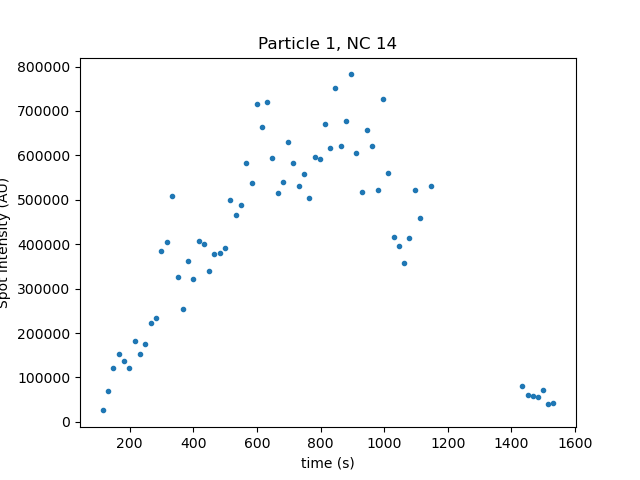

In [15]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

traces = plottable.generate_trace_plot_list(compiled_dataframe)

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")
    ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")
ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")

plt.show()

In [16]:
from tracking import detect_mitosis

In [17]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
viewer.add_labels(nuclear_tracking.reordered_labels)
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)
viewer.add_image(transcription_channel, name="Transcription Channel")
viewer.add_labels(spot_tracking.reordered_spot_labels))
napari.run()

NameError: name 'spot_labels' is not defined

General procedure for background removal:
1. Blur on xy-lengthscale larger than nuclei, very small z-lengthscale.
2. Automatic threshold and label.
3. Check largest connected component bbox for overlap with top or bottom slice and z-span smaller than predetermined number (either by fraction of z-stack or by absolute length in $\mu m$).
4. If conditions above are met, then that connected component is inverted and passed through as a mask which is applied prior to binarization and watershed segmentation.

## MCP-HaloTag tests

In [6]:
viewer_1 = napari.view_image(channels_full_dataset[0], name="MCP-HaloTag")
napari.run()

In [7]:
halotag_channel = channels_full_dataset[0]

In [8]:
import pipeline

In [9]:
track_spots = pipeline.Spot(
    data=halotag_channel,
    global_metadata=export_global_metadata[0],
    frame_metadata=export_frame_metadata[0],
    labels=None,
    client=client,
)

/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/pipeline.py:608: UserWarning: Resolution is anisotropic in X and Y, segmentation parameters should be handled manually.
  warnings.warn(


In [10]:
track_spots.default_params

{'detect_and_gather_spots_params': {'low_sigma': array([1.924679  , 3.25517155, 3.25517156]),
  'high_sigma': array([3.0794864 , 5.20827448, 5.20827449]),
  'threshold': 'triangle',
  'min_size': 4,
  'connectivity': 1,
  'span': array([10.32566259, 29.10598174, 29.10598179]),
  'pos_columns': ['z', 'y', 'x'],
  'return_bandpass': True,
  'return_spot_mask': True,
  'drop_reverse_time': True},
 'add_fits_spots_dataframe_parallel_params': {'sigma_x_y_guess': 2.9105981738986797,
  'sigma_z_guess': 1.7209437655610338,
  'amplitude_guess': None,
  'offset_guess': None,
  'method': 'trf',
  'inplace': True},
 'track_and_filter_spots_params': {'sigma_x_y_bounds': array([0.72071955, 7.20719548]),
  'sigma_z_bounds': array([0.64035117, 4.0021948 ]),
  'expand_distance': 2,
  'search_range': 58.2119634779736,
  'memory': 2,
  'pos_columns': ['y', 'x'],
  't_column': 'frame_reverse',
  'velocity_predict': True,
  'velocity_averaging': None,
  'min_track_length': 5,
  'choose_by': 'amplitude',
  

In [11]:
track_spots.default_params["track_and_filter_spots_params"]["adaptive_stop"] = 1
track_spots.default_params["track_and_filter_spots_params"]["adaptive_step"] = 0.99

In [12]:
track_spots.extract_spot_traces()

Frame 27: 131 trajectories present.


In [13]:
viewer_1.add_labels(track_spots.reordered_spot_labels)

<Labels layer 'Labels' at 0x7fbd3abc7430>

In [14]:
spot_df = track_spots.spot_dataframe

In [15]:
detected_spots = spot_df[spot_df["particle"] != 0]

In [16]:
detected_spots

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,sigma_x_y,sigma_z,amplitude,offset,cost,norm_cost,intensity_from_fit,particle
26,33,2.178804,155.229233,850.664363,1,1.320002,0,"[[[4, 3, 3, 9, 5, 6, 1, 6, 4, 5, 10, 4, 7, 3, ...","[0, -3, 140, 835]",3.019964,2.490822,7.221529,2.873127,17356.557175,0.002789,2583.719149,566
32,41,2.241861,179.785571,351.713635,1,0.660002,0,"[[[3, 2, 10, 4, 4, 3, 5, 4, 3, 1, 5, 6, 9, 5, ...","[0, -4, 165, 337]",1.178343,1.024202,7.388499,3.739760,20659.663311,0.002974,165.483665,572
41,51,2.241103,253.112415,372.507181,1,1.985001,0,"[[[7, 5, 8, 4, 10, 5, 6, 7, 10, 5, 3, 3, 7, 4,...","[0, -2, 238, 358]",2.426980,2.556695,9.772156,3.701803,22819.706321,0.002363,2317.776424,167
50,62,2.652793,296.265461,188.216537,1,1.320002,0,"[[[4, 3, 6, 4, 4, 2, 3, 1, 3, 6, 4, 3, 2, 10, ...","[0, -3, 281, 173]",1.491029,0.936963,3.791623,3.153563,16826.928926,0.005230,124.391142,354
55,67,6.787672,318.083666,163.242253,1,3.305000,0,"[[[3, 2, 1, 3, 1, 3, 6, 0, 1, 2, 8, 3, 4, 3, 2...","[0, 0, 303, 147]",2.949682,2.883476,8.577185,2.670644,15806.746955,0.002241,3389.075294,476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24332,272,15.790051,15.313843,372.676638,27,370.835001,26,"[[[1, 2, 3, 1, 4, 1, 4, 4, 2, 1, 2, 1, 2, 1, 3...","[26, 10, 0, 358]",2.576836,2.296089,2.019053,2.533697,11586.136344,0.008150,484.819063,164
24333,273,14.397839,17.938632,258.597353,27,369.513000,26,"[[[0, 1, 0, 3, 2, 1, 3, 2, 2, 3, 3, 7, 2, 2, 0...","[26, 8, 3, 243]",1.509298,1.220726,4.750603,2.505670,12002.319417,0.003525,208.058986,165
24338,278,16.036725,265.319072,355.902584,27,370.173000,26,"[[[4, 3, 1, 3, 5, 1, 4, 5, 1, 2, 2, 1, 3, 0, 4...","[26, 9, 251, 340]",1.618697,1.498946,3.532870,2.981109,14413.490570,0.005195,218.531648,167
24349,289,19.673223,34.696786,617.050169,27,370.835001,26,"[[[3, 1, 5, 5, 4, 0, 1, 3, 1, 1, 1, 1, 3, 1, 2...","[26, 10, 14, 594]",3.170571,1.376469,3.447491,2.414203,11844.347266,0.004826,751.301464,170


In [17]:
import matplotlib.pyplot as plt

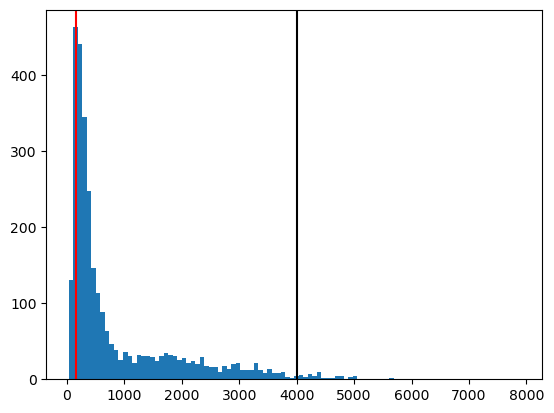

In [23]:
single_mrna_intensity = 160

plt.hist(detected_spots["intensity_from_fit"], bins=100)
plt.axvline(x=single_mrna_intensity, color="red")
plt.axvline(x=single_mrna_intensity * 25, color="black")

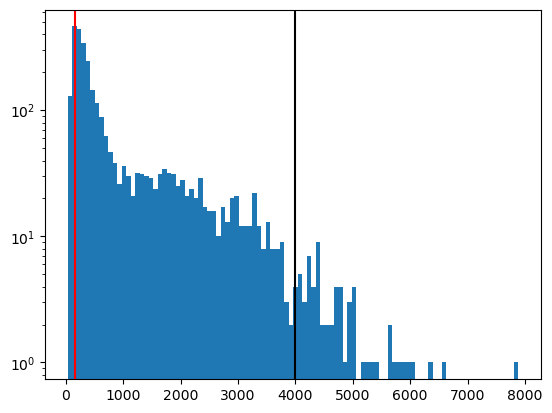

In [24]:
single_mrna_intensity = 160

plt.hist(detected_spots["intensity_from_fit"], bins=100, log=True)
plt.axvline(x=single_mrna_intensity, color="red")
plt.axvline(x=single_mrna_intensity * 25, color="black")

To do:
- ~Add import spot from previous run~
- ~Add import and export results from nuclear analysis~
- Write walkthrough
- Distribute as package
- Write class wrapper around data import functions.